# Museums in the Pandemic - Text analytics

**Authors**: Andrea Ballatore (KCL)

**Abstract**: TODO

## Setup
This is to check that your environment is set up correctly (it should print 'env ok', ignore warnings).

In [22]:
# Test geospatial libraries
# check environment
import os
print("Conda env:", os.environ['CONDA_DEFAULT_ENV'])
if os.environ['CONDA_DEFAULT_ENV'] != 'mip_v1':
    raise Exception("Set the environment 'mip_v1' on Anaconda. Current environment: " + os.environ['CONDA_DEFAULT_ENV'])

# spatial libraries 
import pandas as pd
import pickle
from termcolor import colored
import sys
import spacy
import numpy as np
from numpy import arange
#import tensorflow as tf
from bs4 import BeautifulSoup
from bs4.element import Comment
#import torch
import matplotlib.pyplot as plt

# import from `mip` project
print(os.getcwd())
fpath = os.path.abspath('../')
if not fpath in sys.path:
    sys.path.insert(0, fpath)

out_folder = '../../'

from museums import *
from utils import _is_number

print('env ok')

Conda env: mip_v1
/Users/andreab/Dropbox/DRBX_Docs/Work/Projects/github_projects/museums-in-the-pandemic/mip/notebooks
env ok


# Museum text analytics


## Model1: Vectorise text from museum websites

### Connect to DB

In [22]:
# open connection to DB
from db.db import connect_to_postgresql_db

db_conn = connect_to_postgresql_db()
print("DB connected")

DB connected


### Setup spacy NLP

In [7]:
# install language model
!python -m spacy download en_core_web_sm
# Note: if this cell does not work, run the same command 
#       without "!" in the Anaconda terminal

     |████████████████████████████████| 12.0 MB 5.2 MB/s eta 0:00:01
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.3.1-py3-none-any.whl size=12047106 sha256=6e736cfbfe09463c336696b4717b7863a88b5d6766fe3bbf830fc9b77c861a42
  Stored in directory: /private/var/folders/84/_52b_kt95ybgx9pwl31_nvqh0000gn/T/pip-ephem-wheel-cache-dcoj7ilh/wheels/ee/4d/f7/563214122be1540b5f9197b52cb3ddb9c4a8070808b22d5a84
Successfully built en-core-web-sm
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [5]:
# set up the spacy environment
import spacy
from spacy import displacy
from collections import Counter
spacy.prefer_gpu()
# load language model
import en_core_web_sm
nlp = en_core_web_sm.load()

In [7]:
# Spacy stopwords
#all_stopwords = nlp.Defaults.stop_words

In [8]:
# get text from websites

from analytics.an_websites import get_attribute_for_webpage_url

session_id = '20210420'
test_urls = ['https://www.britishmuseum.org/']
attrib_name = 'all_text' # 'title'

for url in test_urls:
    print(url)
    res = get_attribute_for_webpage_url(url, session_id, attrib_name, db_conn)
    if not res: continue
    print(res)
    blocks = res.split("\n")
    print("LEN", len(blocks))
    print(blocks)

https://www.britishmuseum.org/
Skip to main content Please enable JavaScript in your web browser to get the best experience. We use cookies to make our website work more efficiently, to provide you with more personalised services or advertising to you, and to analyse traffic on our website. For more information on how we use cookies and how to manage cookies, please follow the 'Read more' link, otherwise select 'Accept and close'. Read more about our cookie policy Accept and close the cookie policy Menu Main navigation Visit Toggle Visit submenu Back
to previous menu —
Visit —
Visit —
Family visits —
Group visits —
Audio guide —
Out-of-hours tours —
Tours and talks —
Object trails —
Accessibility —
Food and drink —
Late opening on Fridays —
Museum map Exhibitions and events Collection Toggle Collection submenu Back
to previous menu —
Collection —
Collection —
Collection online —
Galleries —
Blog —
Audio tour highlights —
The British Museum podcast Learn Toggle Learn submenu Back
to pre

### Preprocess text

In [9]:
MOVED

def spacy_extract_tokens(text):
    """ 
    @returns data frame with tokens with POS, lemma, stop words
    """
    tokens_df = pd.DataFrame()
    text_sentences = nlp(text)
    sent_id = 0
    # segment sentences
    for sentence in text_sentences.sents:
        sent_id += 1
        # for each sentence
        snt_text = sentence.text
        pos_df = pd.DataFrame()
        print(colored('>', 'red'), snt_text)
        for token in sentence:
            # for each token
            tokens_df = tokens_df.append(pd.DataFrame(
                {"sentence_id": sent_id, "token":token.text, 'lemma':token.lemma_,
                 "pos_tag":token.pos_, 'is_stop': token.is_stop}, 
                index=[0]), ignore_index=True)
    return tokens_df

test_texts = ["""We need your support Your support is vital and helps the Museum to share the collection with the world. Make a donation What's online... The flowers of Mary Delany 233 years after her death, Delany's detailed floral collages still delight and inspire. Take a closer look at her work in the collection. How to explore the British Museum from home Whether it's a behind-the-scenes podcast or a closer look at our galleries, here are 10 ways to explore the Museum while we're closed. British histories beyond 'Bridgerton' Inspired by the hit Netflix show, watch a panel discussion exploring the reality behind the fantasy of 'Bridgerton'. Discover the Maya World Take a trip to Mexico and explore a wealth of content from the Maya Research Project, including stories, videos and 3D explorations."""]

for tt in test_texts:
    print(tt)
    print("")
    df = spacy_extract_tokens(tt)
    print("Tokens N =",len(df))
    fout = out_folder+'tmp/museum_text_tokens.csv'
    df.to_csv(fout, index=False)
    print("See tokens in",fout)


We need your support Your support is vital and helps the Museum to share the collection with the world. Make a donation What's online... The flowers of Mary Delany 233 years after her death, Delany's detailed floral collages still delight and inspire. Take a closer look at her work in the collection. How to explore the British Museum from home Whether it's a behind-the-scenes podcast or a closer look at our galleries, here are 10 ways to explore the Museum while we're closed. British histories beyond 'Bridgerton' Inspired by the hit Netflix show, watch a panel discussion exploring the reality behind the fantasy of 'Bridgerton'. Discover the Maya World Take a trip to Mexico and explore a wealth of content from the Maya Research Project, including stories, videos and 3D explorations.

> We need your support Your support is vital and helps the Museum to share the collection with the world.
> Make a donation
> What's online...
> The flowers of Mary Delany 233 years after her death, Delany'

### Annotations

In [3]:
# extract tokens from annotations
from analytics.text_models import get_indicator_annotations

indic_df, ann_df = get_indicator_annotations("../../")
ann_df

,text_phrases,indicator_code,indicator_attributes,notes,example_id
0,Closed now,closed_cur,NaN,NaN,0
1,closed to members of the public until further ...,closed_cur,NaN,NaN,1
2,closed until further notice,closed_cur,NaN,NaN,2
3,closed until Spring 2021,closed_cur,NaN,NaN,3
4,Closed: Until further notice,closed_cur,NaN,NaN,4
...,...,...,...,...,...
146,Bailiffgate is now closed due to Covid.,closed_cur,NaN,NaN,146
147,Visit our online shop,open_onlineshop,NaN,NaN,147
148,The new stunning Felton Group online exhibitio...,online_exhib,_description,NaN,148
149,Stay up to date with what's happening at Baili...,online_engag,NaN,NaN,149


In [4]:
ann_tokens_df = pd.DataFrame()

for index, row in ann_df.iterrows():
    txt = str(row['text_phrases']).strip()
    df = spacy_extract_tokens(txt)
    #print(df)
    df['example_id'] = row['example_id']
    df['indicator_code'] = row['indicator_code']
    ann_tokens_df = pd.concat([ann_tokens_df, df])

# output annotations tokens
fout = out_folder+'tmp/test_annotations_tokens.csv'
ann_tokens_df.to_csv(fout, index=False)
print(fout)

NameError: name 'spacy_extract_tokens' is not defined

### Indicator matching

This code identifies indicators in raw text

In [6]:
ftext = out_folder+'tmp/museum_text_tokens.csv'
text_df = pd.read_csv(ftext)
print(len(text_df))
text_df.sample(10)

findic = out_folder+'tmp/test_annotations_tokens.csv'
ann_df = pd.read_csv(findic)
print(len(ann_df))

ann_df

155
1857


,sentence_id,token,lemma,pos_tag,is_stop,example_id,indicator_code
0,1,Closed,close,VERB,False,0,closed_cur
1,1,now,now,ADV,True,0,closed_cur
2,1,closed,close,VERB,False,1,closed_cur
3,1,to,to,ADP,True,1,closed_cur
4,1,members,member,NOUN,False,1,closed_cur
...,...,...,...,...,...,...,...
1852,1,'ve,have,AUX,True,150,made_covid_safe
1853,1,made,make,VERB,True,150,made_covid_safe
1854,1,your,-PRON-,DET,True,150,made_covid_safe
1855,1,visit,visit,NOUN,False,150,made_covid_safe


Options for matches
- Case sensitive/insens (lower case) 
- match lemma
- match token
- stopwords or not

In [9]:
print(text_df.columns)
print(ann_df.columns)

Index(['sentence_id', 'token', 'lemma', 'pos_tag', 'is_stop'], dtype='object')
Index(['sentence_id', 'token', 'lemma', 'pos_tag', 'is_stop', 'example_id',
       'indicator_code'],
      dtype='object')


In [41]:
MOVED

def _filter_tokens(df, keep_stopwords=True):
    """ Remove tokens that do not carry semantic content """
    
    if not keep_stopwords:
        df = df[~df['is_stop']]
    
    filt_df = df[~df['pos_tag'].isin(['DET','ADP','PRON','PUNCT'])]
    return filt_df


def _match_tokens(musetxt_df, annot_df, case_sensitive, keep_stopwords):
    """
    TODO
    """
    assert len(musetxt_df)>=0
    assert len(annot_df)>=0
    # set up options
    prefix = 'var_'
    suffix = ''
    if case_sensitive: suffix = '_csens'
    else: suffix = '_cinsens'
    if case_sensitive: suffix = '_csens'
    else: suffix = '_cinsens'
        
    if keep_stopwords: suffix += '_wstopw'
    else: suffix += '_nostopw'
        
    # filter tokens
    filt_text_df = _filter_tokens(musetxt_df, keep_stopwords)
    filt_ann_df = _filter_tokens(annot_df, keep_stopwords)
    
    # case in/sensitive
    if not case_sensitive:
        # make lower case
        filt_text_df.loc[:, 'lemma'] = filt_text_df.loc[:, 'lemma'].str.lower()
        filt_text_df.loc[:, 'token'] = filt_text_df.loc[:, 'token'].str.lower()
        filt_ann_df.loc[:, 'lemma'] = filt_ann_df.loc[:, 'lemma'].str.lower()
        filt_ann_df.loc[:, 'token'] = filt_ann_df.loc[:, 'token'].str.lower()
        
    # generate match variables for each example/text pair
    lemmas_df = filt_text_df.merge(filt_ann_df, on=['lemma'])
    tokens_df = filt_text_df.merge(filt_ann_df, on=['token'])
    lemmas_m = " ".join(lemmas_df['lemma'].tolist())
    tokens_m = " ".join(tokens_df['token'].tolist())
    vars_d = {
        prefix+'lemmas_n'+suffix:len(lemmas_df), 
        prefix+'lemmas_m'+suffix: lemmas_m, 
        prefix+'tokens_n'+suffix:len(tokens_df),
        prefix+'tokens_m'+suffix: tokens_m
    }
    return vars_d


def match_musetext_indicators(muse_id, txt_df, annot_df):
    """ Main match loop between set of sentences and set of annotations """
    assert muse_id
    assert len(txt_df) >= 0
    assert len(annot_df) >= 0
    
    df = pd.DataFrame()
    
    for sentence_name, txt_sent_df in txt_df.groupby('sentence_id'):
        #print(txt_sent_df)
        for ann_name, ann_example_df in annot_df.groupby('example_id'):
            #print(ann_example_df)
            tmpdf = _match_musetext_vs_indicator_example(muse_id, txt_sent_df, ann_example_df)
            df = df.append(tmpdf)
    
    df.reset_index()
    return df

    
def _match_musetext_vs_indicator_example(muse_id, txt_df, annot_df):
    """ 
    Match single text sentence with single annotation example
    """
    #print("_match_musetext_vs_indicator_example")
    # get txt sentence id
    sentence_id = txt_df['sentence_id'].tolist()[0]
    # get annotation example id and code
    example_id = annot_df['example_id'].tolist()[0]
    indicator_code = annot_df['indicator_code'].tolist()[0]
    
    d = {}
    for cs in [True, False]:
        for sw in [True, False]:
            #print('debug 2')
            match_vars_d = _match_tokens(txt_df, annot_df, cs, sw)
            d.update(match_vars_d)
    
    # sum all values
    all_nums = [x for x in d.values() if _is_number(x)]
    d['all_sum_n'] = sum(all_nums)
    
    # base dictionary
    res_d = {'muse_id':muse_id, 
             'muse_text_sentence_id': [sentence_id], 
             'annotation_example_id':[example_id],
             'muse_text_sentence_len': len(txt_df), 
             'annotation_example_len': len(annot_df)}
    res_d.update(d)
    
    res_df = pd.DataFrame(data=res_d)
    assert len(res_df)>0
    return res_df

In [42]:
# call test match 
muse_id = 'test.123'
df = match_musetext_indicators(muse_id, text_df, ann_df)

print(len(df))
fout = out_folder + 'tmp/all_matches_test.csv'
df.to_csv(fout, index=False)

1510


In [71]:
OLD
# iterate over each group
#for group_name, df_group in df1_grouped:
    
    # match lemmas
    matched_df = filt_text_df.merge(filt_ann_df, on=target_col, suffixes=('_txt', '_ann'))
    print(matched_df.columns)
    matched_df.to_csv(out_folder+'tmp/indic_match_counts_all.csv', index=False)

    df = matched_df.groupby(['sentence_id_txt','example_id','indicator_code']).size().reset_index(name='n_match_'+target_col)
    print(df)
    df.to_csv(out_folder+'tmp/indic_match_counts_counts.csv', index=False)
    #return df
    
mdf = match_tokens(text_df, ann_df, 'lemma')
tdf = match_tokens(text_df, ann_df, 'token')
all_matches_df = mdf.merge(tdf, on=['sentence_id_txt','example_id','indicator_code'], how='outer')

all_matches_df['n_match_lemma'] = all_matches_df['n_match_lemma'].fillna(0)
all_matches_df['n_match_token'] = all_matches_df['n_match_token'].fillna(0)
all_matches_df

Index(['sentence_id', 'token', 'lemma', 'pos_tag', 'is_stop'], dtype='object')
Index(['sentence_id', 'token', 'lemma', 'pos_tag', 'is_stop', 'example_id',
       'indicator_code'],
      dtype='object')


NameError: name 'df1_grouped' is not defined

# Text analysis from DB

Analyse text stats from DB

In [26]:
mus_df = get_museums_sample_urls(out_folder)

museums urls: ../../data/museums/correct_url_stratified_sample_401.tsv
get_museums_w_web_urls Museums=400 URLs=400


In [24]:
assert db_conn

t = "analytics.text_indic_ann_matches"
sql = """select count(distinct muse_id) from {} t;""".format(t)
print(sql)
df = pd.read_sql(sql, db_conn)
df

select count(distinct muse_id) from analytics.text_indic_ann_matches t;


,count
0,357


In [28]:
# get sample of matches museums
sample_df = mus_df.sample(10)
muse_ids = sample_df.muse_id.tolist()
muse_ids = str(muse_ids).replace('[','(').replace(']',')')
#print(muse_ids)
sql = """select * from {} t where muse_id in {};""".format(t, muse_ids)
print(sql)
df = pd.read_sql(sql, db_conn)

fn = out_folder + 'tmp/match_samples.tsv'
print(df.keep_stopwords.describe())
df.to_csv(fn, sep='\t', index=False)
df.describe().transpose()
df.columns

select * from analytics.text_indic_ann_matches t where muse_id in ('mm.mald.030', 'mm.wiki.253', 'mm.domus.SE525', 'mm.mgs.415', 'mm.New.74', 'mm.misc.230', 'mm.domus.SE061', 'mm.domus.NI003', 'mm.wiki.141', 'mm.ace.1187');
count     16611
unique        1
top        True
freq      16611
Name: keep_stopwords, dtype: object


Index(['example_id', 'indicator_code', 'lemma_n', 'lemma_n_wdupl', 'token_n',
       'token_n_wdupl', 'sentence_id', 'sent_len', 'example_len',
       'ann_overlap_lemma', 'ann_overlap_token', 'txt_overlap_lemma',
       'txt_overlap_token', 'ann_ex_tokens', 'page_tokens', 'session_id',
       'page_id', 'muse_id', 'keep_stopwords'],
      dtype='object')

In [29]:
# get all matches from DB (SLOW)
sql = """select muse_id, example_id, sentence_id, indicator_code, token_n, lemma_n, ann_overlap_lemma, ann_overlap_token, example_len, ann_ex_tokens, page_tokens
    from analytics.text_indic_ann_matches t where keep_stopwords;"""
df = pd.read_sql(sql, db_conn)
print(len(df))

# write df to file
matches_fn = out_folder+'tmp/matches_dump_df.pik'
df.to_pickle(matches_fn)

883265


## Load matches from pik

In [4]:
matches_fn = out_folder+'tmp/matches_dump_df.pik'
df = pd.read_pickle(matches_fn)

# generate derived fields
df["lemmatoken_n"] = df[["lemma_n", "token_n"]].max(axis=1)
df["lemmatoken_n"].describe()

df["ann_overlap_tokenlemma"] = df["lemmatoken_n"]/df['example_len']

assert df.ann_overlap_tokenlemma.between(0,1).all(),'incorrect range'

df.sample(10)

,muse_id,example_id,sentence_id,indicator_code,token_n,lemma_n,ann_overlap_lemma,ann_overlap_token,example_len,ann_ex_tokens,page_tokens,lemmatoken_n,ann_overlap_tokenlemma
784116,mm.domus.WM115,ann_ex_00274,mus_page419620_sent00003,staff_working,2.0,2.0,0.25000,0.25000,8,we will use time to continue make improvements,we hope to able to open limited open days when...,2.0,0.250000
676960,mm.domus.SW041,ann_ex_00228,mus_page977800_sent00006,reopen_intent,2.0,2.0,0.66667,0.66667,3,we can reopen,we shall we can to help you family warminster ...,2.0,0.666667
880614,mm.wiki.100,ann_ex_00078,mus_page867282_sent00015,funding_fundraise,0.0,1.0,0.16667,0.00000,6,thank you everyone who supported campaigns,yeomen scheme enables former cadets to retain ...,1.0,0.166667
676848,mm.domus.SW041,ann_ex_00178,mus_page977800_sent00005,online_engag,1.0,1.0,0.11111,0.11111,9,please keep checking our website social media ...,please feel free to contact museum mail address,1.0,0.111111
122312,mm.domus.SE340,ann_ex_00029,mus_page754488_sent00190,closed_cur,1.0,1.0,0.25000,0.25000,4,we to close museum,to find more including how to control cookies ...,1.0,0.250000
768032,mm.musa.149,ann_ex_00283,mus_page438318_sent00009,open_onlineshop,1.0,1.0,0.16667,0.16667,6,our shop will offering online sales,we ’re sorry to announce tramway will not open...,1.0,0.166667
562675,mm.hha.011,ann_ex_00159,mus_page524641_sent00111,lang_difficulty,1.0,1.0,0.20000,0.20000,5,these will undoubtedly difficult times,you also option opt out these cookies,1.0,0.200000
41033,mm.wiki.256,ann_ex_00141,mus_page664754_sent00301,lang_difficulty,1.0,1.0,0.33333,0.33333,3,struggles we faced,we wednesday afternoon,1.0,0.333333
328522,mm.aim.1295,ann_ex_00039,mus_page979535_sent00018,closed_indef,1.0,1.0,0.20000,0.20000,5,suspend museum events foreseeable future,due current covid emergency uk government advi...,1.0,0.200000
110460,mm.aim.1209,ann_ex_00234,mus_page534144_sent00026,reopen_intent,1.0,1.0,0.25000,0.25000,4,when we open season,online shop located beautiful county norfolk w...,1.0,0.250000


## Descriptive stats

### Match distributions

In [5]:
# descriptive stats of all values
#df.groupby('keep_stopwords').describe().transpose()
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
token_n,883265.0,1.030551,0.497137,0.000000,1.00000,1.000000,1.00,8.0
lemma_n,883265.0,1.124612,0.441228,0.000000,1.00000,1.000000,1.00,8.0
ann_overlap_lemma,883265.0,0.203200,0.124995,0.000000,0.12500,0.166670,0.25,1.0
ann_overlap_token,883265.0,0.186740,0.131619,0.000000,0.11111,0.166670,0.25,1.0
example_len,883265.0,6.751379,3.198704,1.000000,4.00000,6.000000,8.00,17.0
lemmatoken_n,883265.0,1.146149,0.420205,1.000000,1.00000,1.000000,1.00,8.0
ann_overlap_tokenlemma,883265.0,0.209669,0.127575,0.058824,0.12500,0.166667,0.25,1.0


### Indicator stats

In [6]:
# describe indicators
indic_df = round(df['indicator_code'].value_counts(normalize=True)*100,1)
indic_df.columns = ['n_matches']
indic_df.to_csv(out_folder + 'tmp/indicator_stats.csv')
print('N matches =',len(df))
indic_df

N matches = 883265


funding_fundraise      18.5
reopen_intent          13.8
closed_cur             12.7
lang_difficulty        12.6
staff_working           6.2
open_onlineshop         4.8
funding_gov_emer        3.8
online_engag            3.7
staff_hiring            3.2
finance_health          2.7
funding_other_emer      2.6
reopen_plan             2.5
funding_did_not_get     2.3
closed_perm             2.0
online_event            1.9
closed_indef            1.6
open_cur                1.5
online_exhib            1.2
project_postpone        1.1
made_covid_safe         0.6
open_cafe               0.4
open_garden             0.3
staff_restruct          0.1
Name: indicator_code, dtype: float64

                 count      mean       std  min  25%  50%  75%  max
token_n       883265.0  1.030551  0.497137  0.0  1.0  1.0  1.0  8.0
lemma_n       883265.0  1.124612  0.441228  0.0  1.0  1.0  1.0  8.0
lemmatoken_n  883265.0  1.146149  0.420205  1.0  1.0  1.0  1.0  8.0


array([[<AxesSubplot:title={'center':'token_n'}>,
        <AxesSubplot:title={'center':'lemma_n'}>],
       [<AxesSubplot:title={'center':'lemmatoken_n'}>, <AxesSubplot:>]],
      dtype=object)

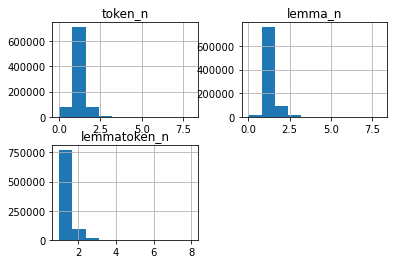

In [7]:
# distribution token_n and lemma_n
print(df[['token_n','lemma_n','lemmatoken_n']].describe().transpose())
df[['token_n','lemma_n','lemmatoken_n']].hist(bins=10)

array([[<AxesSubplot:title={'center':'lemmatoken_n'}>]], dtype=object)

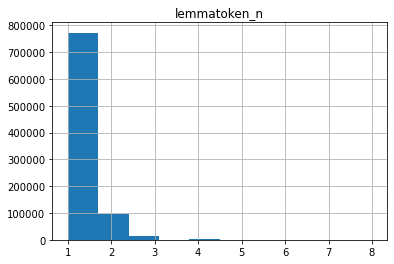

In [245]:
df[['lemmatoken_n']].hist(bins=10)

             lemma_n
count  107526.000000
mean        2.167718
std         0.468068
min         2.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         8.000000


array([[<AxesSubplot:title={'center':'lemma_n'}>]], dtype=object)

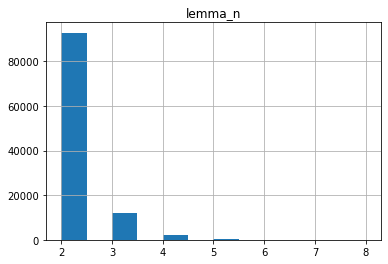

In [32]:
# exclude one match
print(df[['lemma_n']][df.lemma_n > 1].describe())
df[['lemma_n']][df.lemma_n > 1].hist(bins=12)

### Overlaps distributions

                           count      mean       std       min      25%  \
ann_overlap_token       883265.0  0.186740  0.131619  0.000000  0.11111   
ann_overlap_lemma       883265.0  0.203200  0.124995  0.000000  0.12500   
ann_overlap_tokenlemma  883265.0  0.209669  0.127575  0.058824  0.12500   

                             50%   75%  max  
ann_overlap_token       0.166670  0.25  1.0  
ann_overlap_lemma       0.166670  0.25  1.0  
ann_overlap_tokenlemma  0.166667  0.25  1.0  


array([[<AxesSubplot:title={'center':'ann_overlap_tokenlemma'}>]],
      dtype=object)

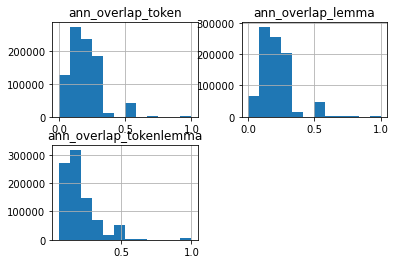

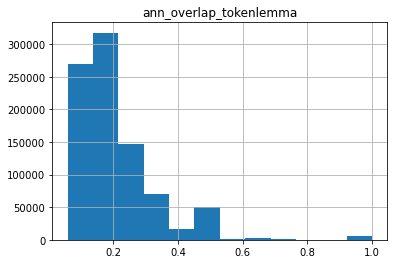

In [33]:
print(df[['ann_overlap_token','ann_overlap_lemma','ann_overlap_tokenlemma']].describe().transpose())
df[['ann_overlap_token','ann_overlap_lemma','ann_overlap_tokenlemma']].hist(bins=12)

df[['ann_overlap_tokenlemma']].hist(bins=12)

count    883265.000000
mean          6.751379
std           3.198704
min           1.000000
25%           4.000000
50%           6.000000
75%           8.000000
max          17.000000
Name: example_len, dtype: float64
matches with annotations > 1: 880779


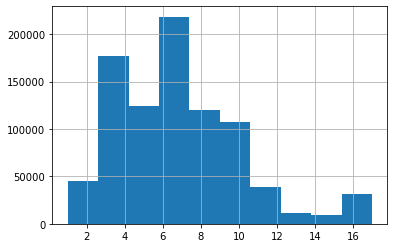

In [34]:
# show length of annotations
print(df['example_len'].describe())
df['example_len'].hist(bins=10)

# filter annotations that are too short: valid df
df = df[df['example_len']>1]
print('matches with annotations > 1:', len(df))

In [8]:
# count number of examples
indic_df = df[['indicator_code','example_id']].groupby(['indicator_code']).describe()
indic_df = indic_df.sort_values(('example_id', 'unique'), ascending=False)
indic_df

example_id                            
                         count unique           top   freq
indicator_code                                            
funding_fundraise       163824     52  ann_ex_00102   6981
reopen_intent           121752     42  ann_ex_00256   5979
lang_difficulty         110903     39  ann_ex_00163   7626
closed_cur              112422     38  ann_ex_00029   7942
funding_gov_emer         33678     13  ann_ex_00121   6022
online_engag             32445     12  ann_ex_00176   6967
open_onlineshop          42028     11  ann_ex_00205   6593
staff_working            55064     11  ann_ex_00275   6886
online_event             16575      9  ann_ex_00190   3871
staff_hiring             28282      8  ann_ex_00268   6396
funding_did_not_get      20342      7  ann_ex_00055   6001
online_exhib             10211      7  ann_ex_00196   4406
closed_indef             14219      6  ann_ex_00042   3908
finance_health           23678      6  ann_ex_00054   6519
closed_perm              17586      5  ann_ex_00048   5185
funding_other_emer       23012      4  ann_ex_00130  10540
reopen_plan              21967      4  ann_ex_00261   6252
open_cur                 13590      3  ann_ex_00202   9380
project_postpone          9880      3  ann_ex_00215   6015
made_covid_safe           5184      1  ann_ex_00170   5184
open_cafe                 3577      1  ann_ex_00199   3577
open_garden               2561      1  ann_ex_00203   2561
staff_restruct             485      1  ann_ex_00271    485

## Evaluation of matching method

### Make match sample stratified on overlap bins

Choose sample for manual annotation of matches

In [9]:
df['ann_overlap_tokenlemma']
cut_bins = [0, .25, .5, .6, .7, .8, .9, 1.01]
df['overlap_bin'] = pd.cut(df['ann_overlap_tokenlemma'], bins=cut_bins)
df['overlap_bin'].value_counts()

(0.0, 0.25]    722928
(0.25, 0.5]    149050
(0.9, 1.01]      5227
(0.6, 0.7]       3106
(0.5, 0.6]       1581
(0.7, 0.8]       1215
(0.8, 0.9]        158
Name: overlap_bin, dtype: int64

In [10]:
# less than 0.2% of cases have annotation length == 1
#(len(df[df.example_len == 1])/len(df))*100

#df = df[df.example_len > 1]
df.example_len.describe()

count    883265.000000
mean          6.751379
std           3.198704
min           1.000000
25%           4.000000
50%           6.000000
75%           8.000000
max          17.000000
Name: example_len, dtype: float64

In [11]:
sample_df = pd.DataFrame()
sample_n = 100
for bin_name, subdf in df.groupby('overlap_bin'):
    smpl = subdf.sample(sample_n, random_state=1359)
    sample_df = sample_df.append(smpl)
    
sample_df['overlap_bin'].value_counts()

sample_df['valid_match'] = ''

# shuffle sample
sample_df = sample_df.sample(frac=1.0)

# generate sample
sample_df.to_csv(out_folder+'tmp/match_sample_for_validation.tsv', index=False, sep='\t')
sample_df.to_excel(out_folder+'tmp/match_sample_for_validation.xlsx', index=False)

sample_df

,muse_id,example_id,sentence_id,indicator_code,token_n,lemma_n,ann_overlap_lemma,ann_overlap_token,example_len,ann_ex_tokens,page_tokens,lemmatoken_n,ann_overlap_tokenlemma,overlap_bin,valid_match
873099,mm.aim.0112,ann_ex_00251,mus_page599129_sent00016,reopen_intent,5.0,5.0,0.83333,0.83333,6,look forward welcoming you again soon,we look forward seeing you again soon,5.0,0.833333,"(0.8, 0.9]",
356289,mm.nimc.009,ann_ex_00272,mus_page591031_sent00055,staff_working,1.0,1.0,0.16667,0.16667,6,team continues to work winter months,booking information contact holidays team sign...,1.0,0.166667,"(0.0, 0.25]",
390682,mm.domus.SC289,ann_ex_00025,mus_page520643_sent00055,closed_cur,3.0,3.0,0.75000,0.75000,4,currently closed government advice,library currently closed government restrictions,3.0,0.750000,"(0.7, 0.8]",
722505,mm.aim.1022,ann_ex_00145,mus_page439904_sent00018,lang_difficulty,2.0,2.0,0.28571,0.28571,7,we to make some changes order survive,seed potatoes onion sets compost plants may st...,2.0,0.285714,"(0.25, 0.5]",
632814,mm.domus.SW238,ann_ex_00030,mus_page121939_sent00033,closed_cur,4.0,4.0,0.80000,0.80000,5,currently closed line government restrictions,line government guidance house currently closed,4.0,0.800000,"(0.7, 0.8]",
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222113,mm.New.103,ann_ex_00248,mus_page601250_sent00037,reopen_intent,5.0,5.0,0.83333,0.83333,6,look forward welcoming you again soon,we look forward welcoming you back safely soon...,5.0,0.833333,"(0.8, 0.9]",
443107,mm.New.66,ann_ex_00256,mus_page420402_sent00025,reopen_intent,5.0,5.0,0.62500,0.62500,8,we intend to open again fully very soon,we will open again soon it safe to so so pleas...,5.0,0.625000,"(0.6, 0.7]",
349031,mm.domus.NI024,ann_ex_00132,mus_page247795_sent00090,lang_difficulty,1.0,2.0,0.66667,0.33333,3,to cover shortfall,line government guidance you required to wear ...,2.0,0.666667,"(0.6, 0.7]",
86443,mm.misc.015,ann_ex_00251,mus_page563788_sent00014,reopen_intent,5.0,5.0,0.83333,0.83333,6,look forward welcoming you again soon,our doors currently closed we look forward wel...,5.0,0.833333,"(0.8, 0.9]",


### Load matching eval dataset

Manually annotated by AB, AP, PW

In [157]:
valid_ann_df = pd.read_excel(out_folder+'data/annotations/match_sample_for_validation-v4.xlsx')
print(len(valid_ann_df))
valid_ann_df['valid_match_b'] = valid_ann_df['valid_match'].map({'T': True, 'F': False})
valid_ann_df['valid_match_b2'] = valid_ann_df['valid_match_2'].map({'T': True, 'F': False})
valid_ann_df.sample(10)

700


,muse_id,example_id,sentence_id,indicator_code,token_n,lemma_n,ann_overlap_lemma,ann_overlap_token,example_len,ann_ex_tokens,page_tokens,lemmatoken_n,ann_overlap_tokenlemma,overlap_bin,valid_match,annotator,valid_match_2,Unnamed: 17,valid_match_b,valid_match_b2
349,mm.domus.NW070,ann_ex_00037,mus_page15046_sent00031,closed_cur,1,1,0.50000,0.50000,2,currently closed,museum temporarily closed opening times,1,0.500000,"(0.25, 0.5]",F,AB,T,NaN,False,True
424,mm.domus.YH045,ann_ex_00256,mus_page95027_sent00015,reopen_intent,1,1,0.12500,0.12500,8,we intend to open again fully very soon,there mill current site we produce range stone...,1,0.125000,"(0.0, 0.25]",F,PW,F,NaN,False,False
468,mm.domus.SW026,ann_ex_00232,mus_page561439_sent00014,reopen_intent,1,2,0.40000,0.20000,5,we look forward seeing again,we hold regular coffee mornings every weeks tu...,2,0.400000,"(0.25, 0.5]",F,PW,F,NaN,False,False
292,mm.wiki.147,ann_ex_00008,mus_page895932_sent00001,closed_cur,2,1,0.50000,1.00000,2,museum closed,museum now closed will reopen,2,1.000000,"(0.9, 1.01]",T,AB,T,NaN,True,True
205,mm.MDN.036,ann_ex_00199,mus_page1015966_sent00025,open_cafe,2,2,0.66667,0.66667,3,our cafe open,we hope to re open our community run museum we...,2,0.666667,"(0.6, 0.7]",F,AB,F,NaN,False,False
293,mm.domus.SE340,ann_ex_00058,mus_page754488_sent00033,funding_did_not_get,1,2,0.50000,0.25000,4,we overlooked grant funding,new trust will take responsibility museum its ...,2,0.500000,"(0.25, 0.5]",F,AB,F,NaN,False,False
102,mm.hha.074,ann_ex_00255,mus_page724659_sent00008,reopen_intent,5,5,0.83333,0.83333,6,we look forward welcoming back soon,step back history elegance our grade neo gothi...,5,0.833333,"(0.8, 0.9]",T,AB,T,NaN,True,True
232,mm.domus.YH049,ann_ex_00206,mus_page219438_sent00003,open_onlineshop,1,1,0.50000,0.50000,2,web shop,gallery railway carriages visit us reopening s...,1,0.500000,"(0.25, 0.5]",F,AB,F,NaN,False,False
334,mm.ace.1103,ann_ex_00211,mus_page525101_sent00058,open_onlineshop,4,4,1.00000,1.00000,4,visit our online shop,visit our online shop,4,1.000000,"(0.9, 1.01]",T,AB,T,NaN,True,True
539,mm.domus.NI024,ann_ex_00208,mus_page247795_sent00184,open_onlineshop,2,2,1.00000,1.00000,2,online shop,centre online shop help centre venue hire resi...,2,1.000000,"(0.9, 1.01]",T,PW,T,NaN,True,True


In [168]:
valid_ann_df.valid_match.describe()
print(valid_ann_df.valid_match_b.value_counts())
print(valid_ann_df.valid_match_b2.value_counts())

# compare different annotators
valid_ann_df['valid_equal'] = valid_ann_df.valid_match_b == valid_ann_df.valid_match_b2
valid_ann_df['valid_equal'].value_counts()
print('mismatch %',round(81/700*100,2))

True     425
False    275
Name: valid_match_b, dtype: int64
True     453
False    246
Name: valid_match_b2, dtype: int64
mismatch % 11.57


### Simple threshold method

In [10]:
len(valid_ann_df)
print(valid_ann_df.ann_overlap_tokenlemma.describe())

count    700.000000
mean       0.629101
std        0.264542
min        0.058824
25%        0.500000
50%        0.666667
75%        0.833333
max        1.000000
Name: ann_overlap_tokenlemma, dtype: float64


In [11]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

# test 
precision_recall_fscore_support([True, False, True, False], [True, False, True, True], average='binary')

(0.6666666666666666, 1.0, 0.8, None)

In [23]:
accuracy_score([True, False, True, False], [True, False, True, True])
for i in : print(i)

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9


In [55]:
thdf = valid_ann_df.copy()

resdf = pd.DataFrame()

# loop through thresholds
for th in arange(.2,1.001,.05):
    print("---\nKeeping values ann_overlap_tokenlemma above: ",th)
    thdf['predicted'] = thdf.ann_overlap_tokenlemma >= th
    precision, recall, fscore, support = precision_recall_fscore_support(thdf.valid_match_b, thdf.predicted, average='binary')
    #print(precision)
    print(thdf.predicted.value_counts())
    stats = classification_report(thdf.valid_match_b, thdf.predicted)
    #print(stats)
    #print(subdf)
    #print(stats)
    resdf = pd.concat([resdf, subdf])
    # confusion matrix
    confmat = confusion_matrix(thdf.valid_match_b, thdf.predicted, normalize='all')
    tn, fp, fn, tp = confmat.ravel()
    print('false positives %:',round(fp*100,1))
    #print(confmat/len(thdf.valid_match_b))
    subdf = pd.DataFrame.from_dict({'threshold':[th], 'precision':[round(precision,3)], 'recall':[round(recall,3)], 
            'fscore':[round(fscore,3)], 
            'accuracy': round(accuracy_score(thdf.valid_match_b, thdf.predicted),3),
            'false_positives': round(fp,3)})
resdf

---
Keeping values ann_overlap_tokenlemma above:  0.2
True     633
False     67
Name: predicted, dtype: int64
false positives %: 30.7
---
Keeping values ann_overlap_tokenlemma above:  0.25
True     616
False     84
Name: predicted, dtype: int64
false positives %: 28.9
---
Keeping values ann_overlap_tokenlemma above:  0.3
True     589
False    111
Name: predicted, dtype: int64
false positives %: 25.6
---
Keeping values ann_overlap_tokenlemma above:  0.35
True     540
False    160
Name: predicted, dtype: int64
false positives %: 19.0
---
Keeping values ann_overlap_tokenlemma above:  0.39999999999999997
True     539
False    161
Name: predicted, dtype: int64
false positives %: 18.9
---
Keeping values ann_overlap_tokenlemma above:  0.44999999999999996
True     531
False    169
Name: predicted, dtype: int64
false positives %: 18.0
---
Keeping values ann_overlap_tokenlemma above:  0.49999999999999994
True     531
False    169
Name: predicted, dtype: int64
false positives %: 18.0
---
Keeping 

,threshold,precision,recall,fscore,accuracy,support,false_positives
0,1.00,0.900,0.212,0.343,0.507,None,NaN
0,0.20,0.660,0.984,0.790,0.683,None,0.307
0,0.25,0.672,0.974,0.795,0.696,None,0.289
0,0.30,0.696,0.965,0.809,0.723,None,0.256
0,0.35,0.754,0.958,0.844,0.784,None,0.190
0,0.40,0.755,0.958,0.844,0.786,None,0.189
0,0.45,0.763,0.953,0.847,0.791,None,0.180
0,0.50,0.763,0.953,0.847,0.791,None,0.180
0,0.55,0.793,0.927,0.855,0.809,None,0.147
0,0.60,0.795,0.922,0.854,0.809,None,0.144


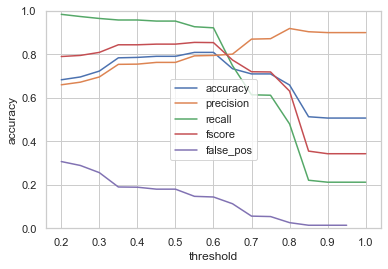

In [56]:
import seaborn as sns
p = sns.lineplot(data=resdf, x="threshold", y="accuracy", label='accuracy')
p = sns.lineplot(data=resdf, x="threshold", y="precision", label='precision')
p = sns.lineplot(data=resdf, x="threshold", y="recall", label='recall')
p = sns.lineplot(data=resdf, x="threshold", y="fscore", label='fscore')
p = sns.lineplot(data=resdf, x="threshold", y="false_positives", label='false_pos')
p.set(ylim=(0,1))
p.legend()

### Logit regression

- https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
- https://www.analyticsvidhya.com/blog/2021/04/beginners-guide-to-logistic-regression-using-python/

In [95]:
# setup logistic regression
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

len(valid_ann_df)

700

- Select variables for regression

In [18]:
valid_ann_df.columns

Index(['muse_id', 'example_id', 'sentence_id', 'indicator_code', 'token_n',
       'lemma_n', 'ann_overlap_lemma', 'ann_overlap_token', 'example_len',
       'ann_ex_tokens', 'page_tokens', 'lemmatoken_n',
       'ann_overlap_tokenlemma', 'overlap_bin', 'valid_match', 'annotator',
       'valid_match_b'],
      dtype='object')

In [75]:
#cols = ['indicator_code','lemmatoken_n','ann_overlap_tokenlemma','example_len']

In [76]:
valid_ann_df['indicator_code'].unique()

array(['reopen_intent', 'closed_cur', 'online_engag', 'funding_fundraise',
       'lang_difficulty', 'staff_working', 'open_onlineshop', 'open_cafe',
       'open_cur', 'online_event', 'project_postpone', 'reopen_plan',
       'closed_indef', 'funding_other_emer', 'staff_hiring',
       'online_exhib', 'finance_health', 'funding_did_not_get',
       'funding_gov_emer', 'closed_perm'], dtype=object)

In [77]:
valid_ann_df.groupby('indicator_code').mean()

,token_n,lemma_n,ann_overlap_lemma,ann_overlap_token,example_len,lemmatoken_n,ann_overlap_tokenlemma,valid_match_b
indicator_code,,,,,,,,
closed_cur,2.171598,2.053254,0.596741,0.650939,3.538462,2.307692,0.693444,0.721893
closed_indef,2.500000,2.400000,0.714166,0.736667,3.400000,2.550000,0.753333,0.750000
closed_perm,1.333333,2.000000,0.326923,0.217950,10.000000,2.000000,0.326923,0.000000
finance_health,2.000000,2.000000,0.400000,0.400000,5.000000,2.000000,0.400000,0.000000
funding_did_not_get,1.000000,1.250000,0.218750,0.156250,7.000000,1.250000,0.218750,0.000000
funding_fundraise,1.840426,2.095745,0.562438,0.483803,4.680851,2.095745,0.562438,0.468085
funding_gov_emer,1.333333,1.333333,0.127273,0.127273,10.333333,1.333333,0.127273,0.333333
funding_other_emer,1.333333,1.333333,0.095173,0.095173,14.000000,1.333333,0.095173,0.000000
lang_difficulty,1.581395,1.790698,0.387403,0.321290,5.255814,1.813953,0.392055,0.023256


In [26]:
valid_ann_df.groupby('valid_match_b').mean()

,token_n,lemma_n,ann_overlap_lemma,ann_overlap_token,example_len,lemmatoken_n,ann_overlap_tokenlemma
valid_match_b,,,,,,,
False,1.570909,1.745455,0.421499,0.377488,5.061818,1.778182,0.433473
True,3.120000,3.207059,0.721880,0.707176,4.512941,3.298824,0.755684


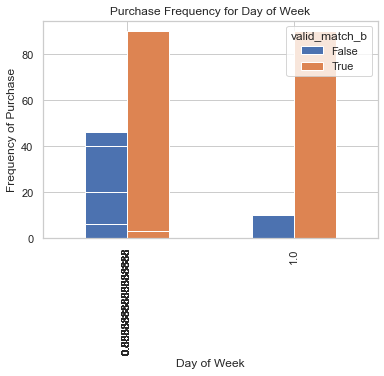

In [78]:
pd.crosstab(valid_ann_df.ann_overlap_tokenlemma, valid_ann_df.valid_match_b).plot(kind='bar')
plt.title('Purchase Frequency for Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_dayofweek_bar')

In [93]:
model_vars = ['lemmatoken_n','ann_overlap_tokenlemma','example_len','lemma_n','valid_match_b']
num_df = valid_ann_df[model_vars]
# 'indicator_code'
num_df.columns

KeyError: "['valid_match_b'] not in index"

#### Model with test/train

In [148]:
# train/test split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict


y_data = num_df['valid_match_b'] 
x_data = num_df.drop('valid_match_b', axis = 1)

x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(x_data, y_data, test_size = 0.3, random_state=42)
print(len(x_training_data), len(x_test_data))

model = LogisticRegression()

# Train the model and create predictions
model.fit(x_training_data, y_training_data)
predictions = model.predict(x_test_data)
print('Coefficients')
print(x_data.columns)
print(model.coef_, model.intercept_)

precision, recall, fscore, support = precision_recall_fscore_support(y_test_data, predictions, average='binary')
#print(classification_report(y_test_data, predictions))
print('precision', round(precision,2), '; recall', round(recall,2), '; fscore', round(fscore,2))

490 210
Coefficients
Index(['lemmatoken_n', 'ann_overlap_tokenlemma', 'example_len', 'lemma_n'], dtype='object')
[[ 1.76438993  1.63320695 -0.28636017 -0.65746185]] [-2.28028408]
precision 0.84 ; recall 0.94 ; fscore 0.89


#### Model with cross validation

- https://scikit-learn.org/stable/modules/cross_validation.html

In [156]:
# predictions with cross-val
predicted = cross_val_predict(LogisticRegression(), x_data, y_data, cv=10)
print(accuracy_score(y_data, predicted))

0.81


Confusion matrix
- true positives: 63%
- true negatives: 19%
- false positives (type I): 12%
- false negatives (type II): 5%

[[0.21428571 0.11904762]
 [0.04285714 0.62380952]]
tn, fp, fn, tp
0.21 0.12 0.04 0.62


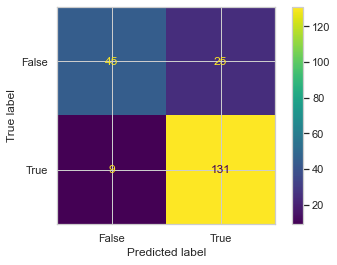

In [155]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

confmat = confusion_matrix(y_test_data, predictions, normalize='all')
print(confmat)
tn, fp, fn, tp = confmat.ravel()
print('tn, fp, fn, tp')
print(round(tn,2), round(fp,2), round(fn,2), round(tp,2))
#print(confmat/len(y_test_data))
plot_confusion_matrix(model, x_test_data, y_test_data)

End of notebook